In [1]:
import uproot
import awkward
import numpy as np
import os
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm

from datasets.graph import graph_to_sparse, save_graph

from preprocessing import *

In [2]:
'''
# for EdgeNet
preprocessing_algo = make_graph_etaphi
grouping_algo = 'knn' #or 'kdtree'
preprocessing_args= dict(k=4)
#preprocessing_args= dict(r = 0.07) #if algo == 'kdtree'
layer_norm = 150 #only used for etaphi, no effect for other preprocessors

fname = '/eos/uscms/store/user/sghosh/HGCFILES/pythia8_PDGid15_x1000_Pt3.0To100.0_NTUP_1.root'

test = uproot.open(fname)['ana']['hgc']

#example of generating a binary ground-truth adjacency matrix 
#for both endcaps in all events for all clusters
#truth is now that hits in adjacent layers are connected 
#and so are hits in the same layer within delta-R < 2 
arrays = test.arrays([b'simcluster_hits_indices'])
rechit = test.arrays([b'rechit_x',b'rechit_y', b'rechit_z', b'rechit_eta', b'rechit_phi',
                      b'rechit_layer',b'rechit_time',b'rechit_energy'])
NEvents = rechit[b'rechit_z'].shape[0]
rechit[b'rechit_x'].content[rechit[b'rechit_z'].content < 0] *= -1
sim_indices = awkward.fromiter(arrays[b'simcluster_hits_indices'])
valid_sim_indices = sim_indices[sim_indices > -1]


'''

"\n# for EdgeNet\npreprocessing_algo = make_graph_etaphi\ngrouping_algo = 'knn' #or 'kdtree'\npreprocessing_args= dict(k=4)\n#preprocessing_args= dict(r = 0.07) #if algo == 'kdtree'\nlayer_norm = 150 #only used for etaphi, no effect for other preprocessors\n\nfname = '/eos/uscms/store/user/sghosh/HGCFILES/pythia8_PDGid15_x1000_Pt3.0To100.0_NTUP_1.root'\n\ntest = uproot.open(fname)['ana']['hgc']\n\n#example of generating a binary ground-truth adjacency matrix \n#for both endcaps in all events for all clusters\n#truth is now that hits in adjacent layers are connected \n#and so are hits in the same layer within delta-R < 2 \narrays = test.arrays([b'simcluster_hits_indices'])\nrechit = test.arrays([b'rechit_x',b'rechit_y', b'rechit_z', b'rechit_eta', b'rechit_phi',\n                      b'rechit_layer',b'rechit_time',b'rechit_energy'])\nNEvents = rechit[b'rechit_z'].shape[0]\nrechit[b'rechit_x'].content[rechit[b'rechit_z'].content < 0] *= -1\nsim_indices = awkward.fromiter(arrays[b'simclu

In [3]:
'''
for ievt in tqdm(range(NEvents),desc='events processed'):
    #make input graphs
    
    # for EdgeNet
    pos_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b'rechit_z'][ievt] > 0,
                                   layered_norm = layer_norm, algo=grouping_algo, preprocessing_args=preprocessing_args)
    neg_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b'rechit_z'][ievt] < 0,
                                   layered_norm = layer_norm, algo=grouping_algo, preprocessing_args=preprocessing_args)
    # for PointNet
    #pos_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b'rechit_z'][ievt] > 0)
    #neg_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b'rechit_z'][ievt] < 0)
    
    #write the graph and truth graph out
#    outbase = fname.split('/')[-1].replace('.root','')
#    outdir = "/".join(fname.split('/')[:-2]) + "/npz/" + outbase + "/raw"
    outdir = "/eos/uscms/store/user/sghosh/HGCFILES/graphs/"
    if not os.path.exists( outdir):
        os.makedirs(outdir)

    # for EdgeNet
#    save_graph(pos_graph, '%s/%s_hgcal_graph_pos_evt%d.npz'%(outdir,outbase,ievt))
#    save_graph(neg_graph, '%s/%s_hgcal_graph_neg_evt%d.npz'%(outdir,outbase,ievt))
    save_graph(pos_graph, '%s/hgcal_graph_pos_evt%d.npz'%(outdir,ievt))
    save_graph(neg_graph, '%s/hgcal_graph_neg_evt%d.npz'%(outdir,ievt))
    #saved as sparse
    
    # for PointNet
    #save_graph(pos_graph, '%s/%s_hgcal_graph_pos_evt%d.npz'%(outdir,outbase,ievt))
    #save_graph(neg_graph, '%s/%s_hgcal_graph_neg_evt%d.npz'%(outdir,outbase,ievt))
'''

'\nfor ievt in tqdm(range(NEvents),desc=\'events processed\'):\n    #make input graphs\n    \n    # for EdgeNet\n    pos_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b\'rechit_z\'][ievt] > 0,\n                                   layered_norm = layer_norm, algo=grouping_algo, preprocessing_args=preprocessing_args)\n    neg_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b\'rechit_z\'][ievt] < 0,\n                                   layered_norm = layer_norm, algo=grouping_algo, preprocessing_args=preprocessing_args)\n    # for PointNet\n    #pos_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b\'rechit_z\'][ievt] > 0)\n    #neg_graph = preprocessing_algo(rechit, valid_sim_indices, ievt = ievt, mask = rechit[b\'rechit_z\'][ievt] < 0)\n    \n    #write the graph and truth graph out\n#    outbase = fname.split(\'/\')[-1].replace(\'.root\',\'\')\n#    outdir = "/".join(fname.split(\'/\')[:-2]

In [2]:
from datasets.graph import *
G = load_graph('/eos/uscms/store/user/sghosh/HGCFILES/graphs/hgcal_graph_pos_evt0.npz')
G._fields


('X', 'Ri', 'Ro', 'y', 'simmatched')

In [3]:
from scipy.sparse import *
from scipy import *
#G.X.shape
G.Ro
#csr_matrix( (data,indices,indptr), shape=(3,3) ).todense()
print (G.Ri[0])
print (G.Ro[0])

[[    0     0     0 ... 21481 21481 21481]
 [    5     8  1649 ...  1292  3277 81764]]
[[    0     0     0 ... 21481 21481 21481]
 [    0     1     2 ... 81853 81854 81855]]


In [4]:
def draw_sampleG(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    # Select the i/o node features for each segment    
    
    
    feats_o = X[Ro]
    feats_i = X[Ri]
#    feats_o = X[Ro][sim_list.T]
#    feats_i = X[Ri][sim_list.T]
    print ('X.shape',X.shape)
    print ('Ro.shape',Ro.shape)
    print ('Ri.shape',Ri.shape)
    print ('y.shape',y.shape)
    print ('feats_o.shape',feats_o.shape)
    print ('sim_list.shape',sim_list.shape)
    print (max(Ro))
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
#    cmap = plt.get_cmap(cmap)
    
#    del X, Ri, Ro, y
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #    ax0.scatter(X[sim_list,0], X[sim_list,2], c='b')
    #    ax1.scatter(X[sim_list,1], X[sim_list,2], c='b')
    
    # Draw the segments
        
     
    if out is not None:
        t = tqdm.tqdm(range(out.shape[0]))
        for j in t:       
            if y[j] and out[j]>0.5: 
                seg_args = dict(c='purple', alpha=0.2) #hadronic edge
            elif y[j] and out[j]<1.5: 
                seg_args = dict(c='blue', alpha=0.2) #EM edge
            elif out[j]>2.5:
                seg_args = dict(c='red', alpha=0.2) #muon edge
            else:
                    continue #false edge

            ax0.plot([feats_o[j,0], feats_i[j,0]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            ax1.plot([feats_o[j,1], feats_i[j,1]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([feats_o[j,0], feats_i[j,0]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            ax1.plot([feats_o[j,1], feats_i[j,1]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        
    # Adjust axes
    ax0.set_xlabel('$x$ [cm]')
    ax1.set_xlabel('$y$ [cm]')
    ax0.set_ylabel('$layer$ [arb]')
    ax1.set_ylabel('$layer$ [arb]')
    plt.tight_layout()
    
    return fig;


  0%|          | 26/81856 [00:00<06:55, 197.10it/s]

(81856,)
X.shape (21482, 5)
Ro.shape (81856,)
Ri.shape (81856,)
y.shape (81856,)
feats_o.shape (81856, 5)
sim_list.shape (2364,)
21481


100%|██████████| 81856/81856 [00:50<00:00, 1612.34it/s] 


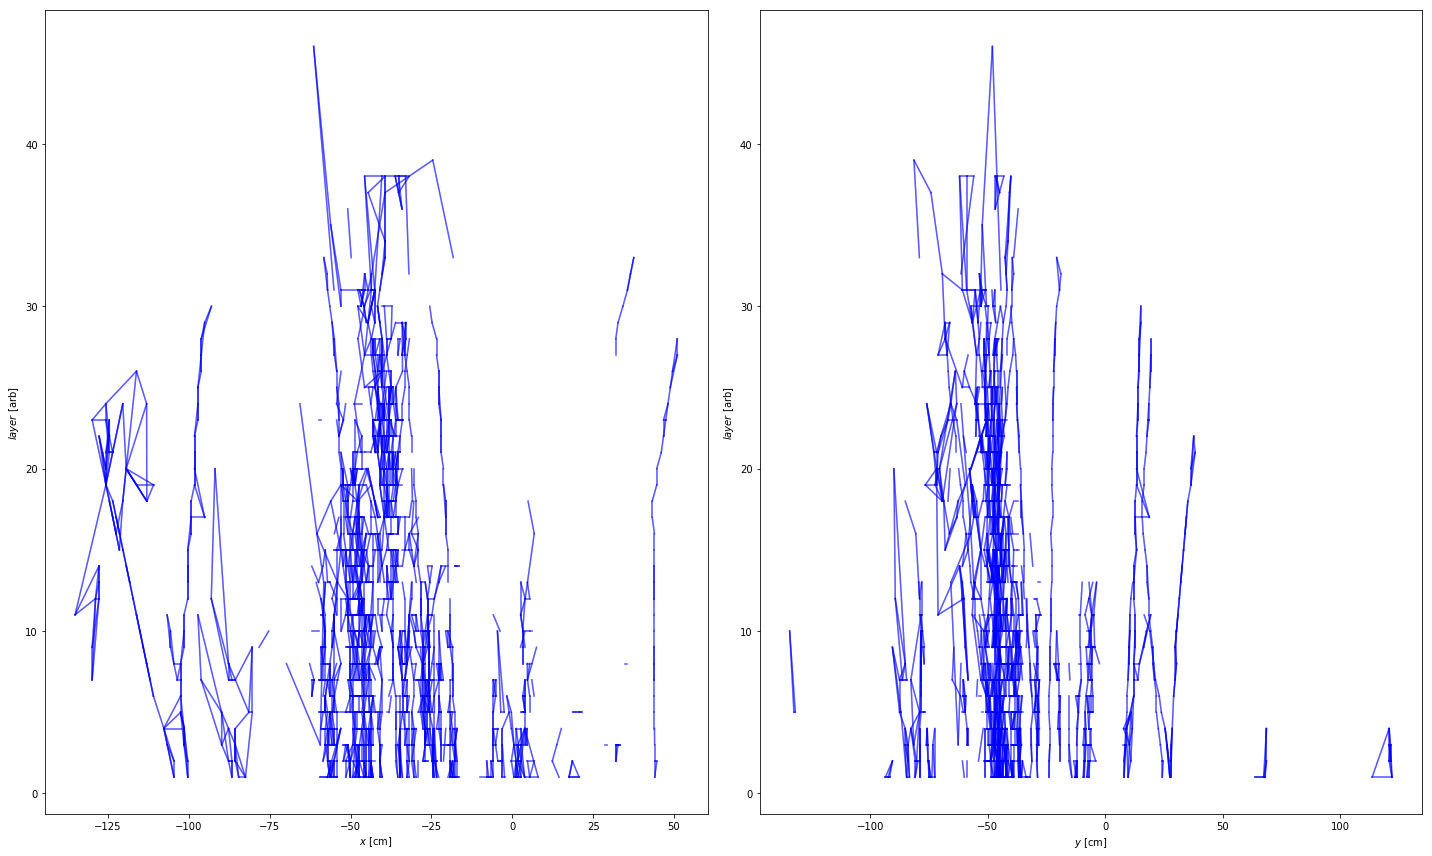

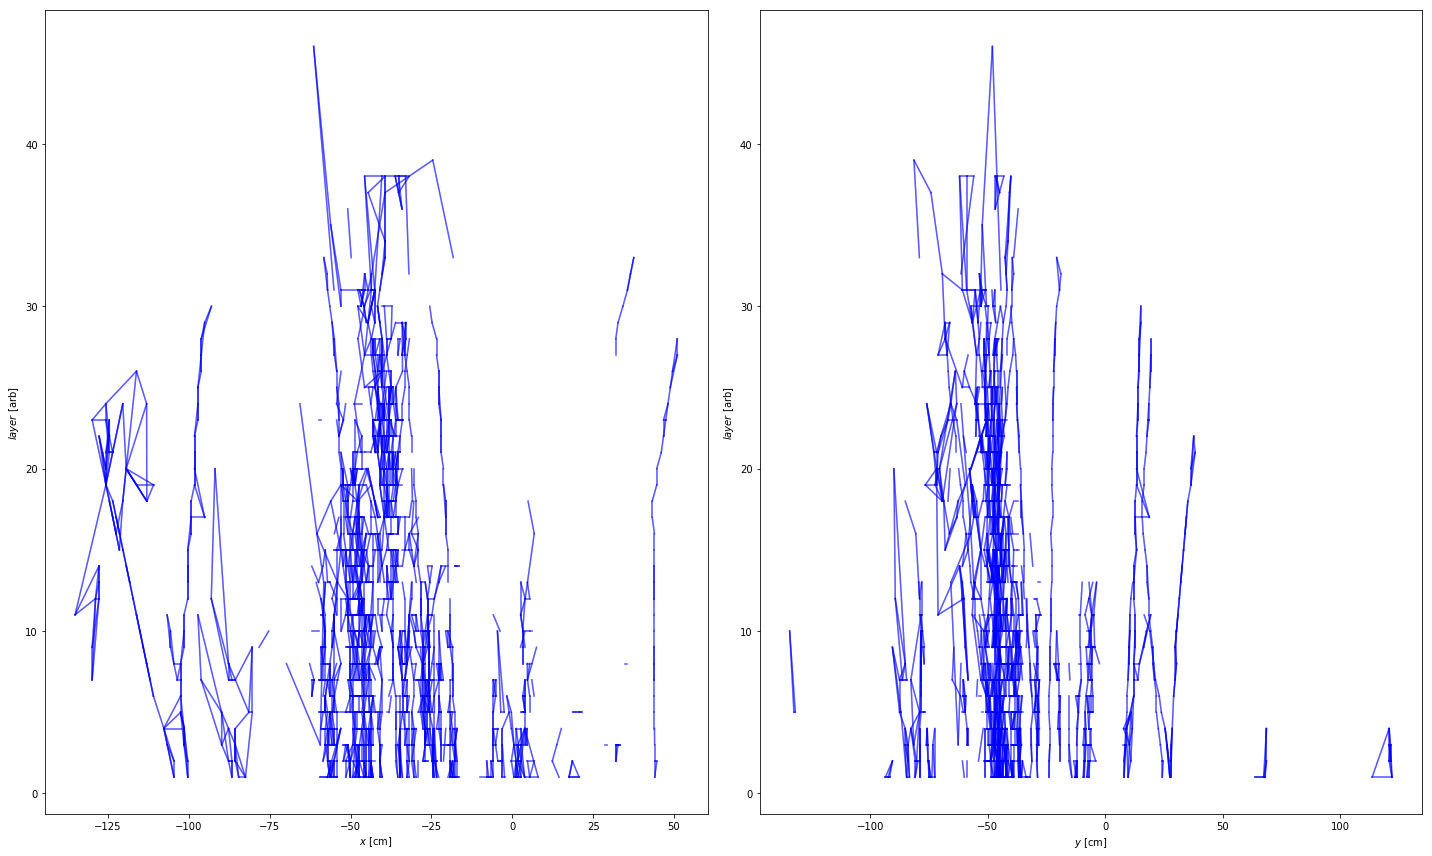

In [5]:
#csr_matrix( (data,(row,col)), shape=(3,3) ).todense()
#from scipy.sparse import *
#from scipy import *
#draw_sample(G.X, G.Ri, G.Ro, G.y,out=None ,
g=G
Ro = g.Ro[0].T.astype(np.int64)
Ri = g.Ri[0].T.astype(np.int64)
i_out = Ro[Ro[:,1].argsort(kind='stable')][:,0]
i_in  = Ri[Ri[:,1].argsort(kind='stable')][:,0]
edge_index = np.stack((i_out,i_in)).T
RO = edge_index[:,0]
RI = edge_index[:,1]
print (G.y.shape)
#edge_index = np.stack((i_out,i_in))
#draw_sampleG(G.X,csr_matrix( (G.Ri[1],(G.Ri[0][0],G.Ri[0][1])), shape=(G.Ri[2],G.Ri[3]),dtype=int ).toarray() , csr_matrix( (G.Ro[1],(G.Ro[0][0],G.Ro[0][1])), shape=(G.Ro[2],G.Ro[3]),dtype=int ).toarray(), G.y,out=None ,
draw_sampleG(G.X, RI, RO, G.y,out=None ,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=G.simmatched)
#                sim_list=None)
#csr_matrix( (G.Ri[1],(G.Ri[0][0],G.Ri[0][1])), shape=(G.Ri[2],G.Ri[3]) ).toarray()

In [40]:
a = array([[1, 2, 3],[4, 5, 6]])
b = array([0,1,0,0,1,1,0],dtype=bool)
c= array([0,1,0,0,1,1,0])

In [41]:
print (a.shape)

print (b.shape)

(2, 3)
(7,)


In [42]:
a[b]
b[bc]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 7

In [11]:
Ro = G.Ro[0].T.astype(np.int64)
i_out = Ro[Ro[:,1].argsort(kind='stable')][:,0]
Ro

array([[    0,     0],
       [    0,     1],
       [    0,     2],
       ...,
       [21481, 81853],
       [21481, 81854],
       [21481, 81855]])

In [12]:
g=G
Ro = g.Ro[0].T.astype(np.int64)
Ri = g.Ri[0].T.astype(np.int64)
            
i_out = Ro[Ro[:,1].argsort(kind='stable')][:,0]
i_in  = Ri[Ri[:,1].argsort(kind='stable')][:,0]
                        
x = g.X.astype(np.float32)
edge_index = np.stack((i_out,i_in))